In [33]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import TargetEncoder

## Анализ данных (типо)

In [34]:
data = pd.read_csv("../data/bmw_preprocessed.csv")
data

,Серия,Поколение,Кузов,Год,Рестайлинг,Пробег,Коробка,Объем,Топливо,Цена
0,1 серия,F40,хэтчбек 5 дв.,2019,0,129000,робот,"1,5 л",дизель,16999
1,7 серия,G12,седан,2019,1,35000,автомат,"3,0 л",дизель,83777
2,5 серия,E39,седан,1999,0,400000,механика,"2,5 л",дизель,3399
3,1 серия,"E81, E82, E88, E87",хэтчбек 5 дв.,2005,0,370000,автомат,"2,0 л",бензин,7200
4,X6,E71,внедорожник 5 дв.,2012,1,149000,автомат,"3,0 л",бензин,23450
...,...,...,...,...,...,...,...,...,...,...
2788,X6,E71,внедорожник 5 дв.,2011,0,277000,автомат,"3,0 л",дизель,22290
2789,5 серия,"F10, F11",седан,2012,0,256000,автомат,"3,0 л",дизель,23500
2790,4 серия,"F32, F33, F36",купе,2013,0,268500,автомат,"2,0 л",бензин,21500
2791,2 серия,F45,минивэн,2017,0,200000,механика,"1,5 л",дизель,13000


In [35]:
# Убираем все объявления с приколхоженным пропаном-бутаном к машине (27 шт.)
data = data[data['Топливо'] != 'бензин (пропан-бутан)']
data['Топливо'].value_counts()

Топливо
бензин    1450
дизель    1316
Name: count, dtype: int64

In [36]:
# Убираем автомобиили с кузовом "родстер" (3 шт.)
data = data[data['Кузов'] != 'родстер']
data['Кузов'].value_counts()

Кузов
седан                1161
внедорожник 5 дв.     879
универсал             289
лифтбек               130
минивэн                91
купе                   79
хэтчбек 5 дв.          71
кабриолет              39
хэтчбек 3 дв.          24
Name: count, dtype: int64

In [37]:
# Удаляем строки, где пробег больше 600000
data = data[data['Пробег'] <= 600000]
data['Пробег'].value_counts(bins=10)

(60912.6, 120811.2]              440
(120811.2, 180709.8]             412
(180709.8, 240608.4]             379
(240608.4, 300507.0]             350
(415.01300000000003, 60912.6]    328
(300507.0, 360405.6]             326
(360405.6, 420304.2]             244
(420304.2, 480202.8]             134
(480202.8, 540101.4]             100
(540101.4, 600000.0]              32
Name: count, dtype: int64

In [38]:
# Удаляем автомобили, у которых объем двигателя встречается менее 10 раз
volume_counts = data['Объем'].value_counts()
volumes_to_keep = volume_counts[volume_counts >= 10].index
data = data[data['Объем'].isin(volumes_to_keep)]
data['Объем'].value_counts()

Объем
2,0 л    989
3,0 л    878
2,5 л    243
1,5 л    242
4,4 л     96
2,9 л     70
1,6 л     55
1,8 л     42
2,8 л     26
2,2 л     26
1,9 л     21
4,8 л     20
Name: count, dtype: int64

In [39]:
# Преобразуем объем двигателя в число
def parse_volume_to_float(volume_str):
    # Удаляем неразрывные пробелы и берем только число (заменяем запятую на точку)
    if isinstance(volume_str, str):
        num = re.match(r"([\d,\.]+)", volume_str.replace('\xa0', ''))
        if num:
            return float(num.group(1).replace(',', '.'))
    return None

data['Объем'] = data['Объем'].apply(parse_volume_to_float)
data['Объем'].info()

<class 'pandas.core.series.Series'>
Index: 2708 entries, 0 to 2791
Series name: Объем
Non-Null Count  Dtype  
--------------  -----  
2708 non-null   float64
dtypes: float64(1)
memory usage: 42.3 KB


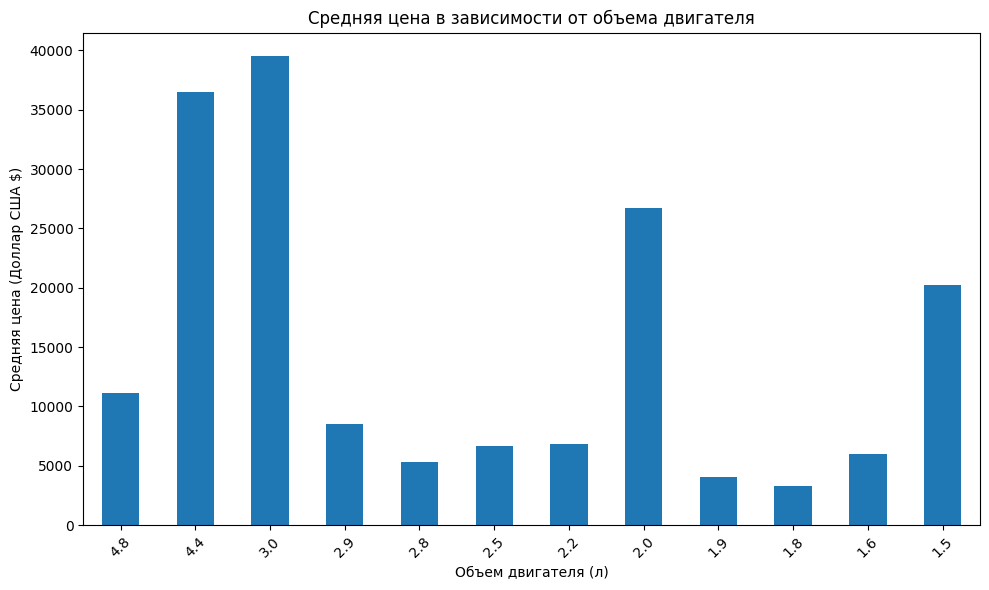

In [40]:
# Группируем и сортируем по среднему значению цены, но индексы (объемы) сортируем по убыванию объема
avg_price_by_volume = (
    data.groupby(['Объем'])['Цена']
    .mean()
    .reset_index()
    .sort_values('Объем', ascending=False)
    .set_index('Объем')
)['Цена']

plt.figure(figsize=(10, 6))
avg_price_by_volume.plot(kind='bar')
plt.xlabel('Объем двигателя (л)')
plt.ylabel('Средняя цена (Доллар США $)')
plt.title('Средняя цена в зависимости от объема двигателя')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
# Удаляем автомобили, у которых поколение встречается менее 10 раз
generation_counts = data['Поколение'].value_counts()
generations_to_keep = generation_counts[generation_counts >= 10].index
data = data[data['Поколение'].isin(generations_to_keep)]
data['Поколение'].value_counts()

Поколение
E39                   246
G30, G31              170
G01                   149
E60, E61              130
E46                   111
F48                   109
G05                   103
G20, G21              101
F30, F31              100
E70                    89
E36                    87
F10, F11               83
E90, E91, E92, E93     70
F46                    66
F44                    64
E53                    63
E71                    58
G22, G23, G26          51
F32, F33, F36          51
F15                    49
E34                    48
I                      46
F01, F04               44
F07                    40
G02                    36
F39                    34
F40                    32
F25                    29
E38                    29
E65, E66               27
E65                    27
F02                    26
G32                    25
G12                    24
G06                    24
F45                    23
E81, E82, E88, E87     22
F34                    22
F2

In [42]:
data.groupby('Поколение')['Цена'].mean()

Поколение
E34                    2887.250000
E36                    2802.298851
E38                    6065.137931
E39                    6025.747967
E46                    5847.153153
E53                   11188.253968
E60, E61              11553.946154
E65                    9177.666667
E65, E66              11065.407407
E70                   18203.550562
E71                   19727.689655
E81, E82, E88, E87     7609.045455
E83                   10280.500000
E84                   12853.333333
E90, E91, E92, E93    10700.900000
F01, F04              18849.931818
F02                   18190.230769
F07                   18675.075000
F10, F11              19628.638554
F15                   34706.632653
F16                   40891.266667
F20, F21              15292.450000
F25                   18738.551724
F30, F31              19412.180000
F32, F33, F36         26527.039216
F34                   23595.454545
F39                   25146.058824
F40                   21430.343750
F44       

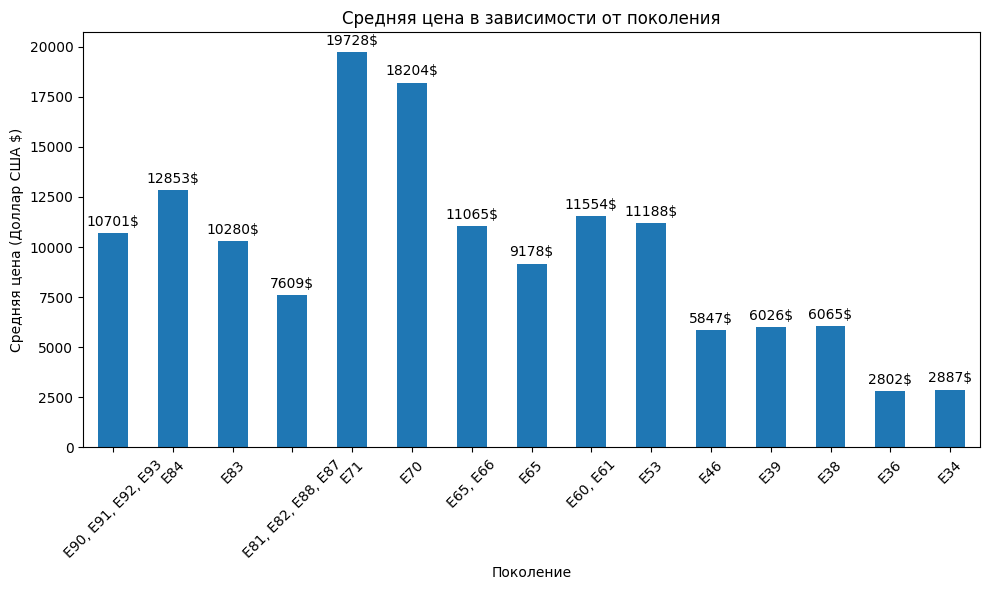

In [43]:
# Группируем и сортируем по среднему значению цены, но индексы (объемы) сортируем по убыванию объема
avg_price_by_generation = (
    data
    .where(data['Поколение'].str.startswith('E'))
    .groupby(['Поколение'])['Цена']
    .mean()
    .reset_index()
    .sort_values('Поколение', ascending=False)
    .set_index('Поколение')
)['Цена']

plt.figure(figsize=(10, 6))
ax = avg_price_by_generation.plot(kind='bar')
ax.bar_label(ax.containers[0], fmt='%.0f$', padding=3)  # fmt задаёт формат чисел
plt.xlabel('Поколение')
plt.ylabel('Средняя цена (Доллар США $)')
plt.title('Средняя цена в зависимости от поколения')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\trxxnk\AppData\Local\Temp\ipykernel_9460\341169350.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e60_61['Пробег_группа'] = pd.cut(e60_61['Пробег'], bins=bins, labels=labels, right=False, include_lowest=True)
C:\Users\trxxnk\AppData\Local\Temp\ipykernel_9460\341169350.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Пробег_группа')['Цена']


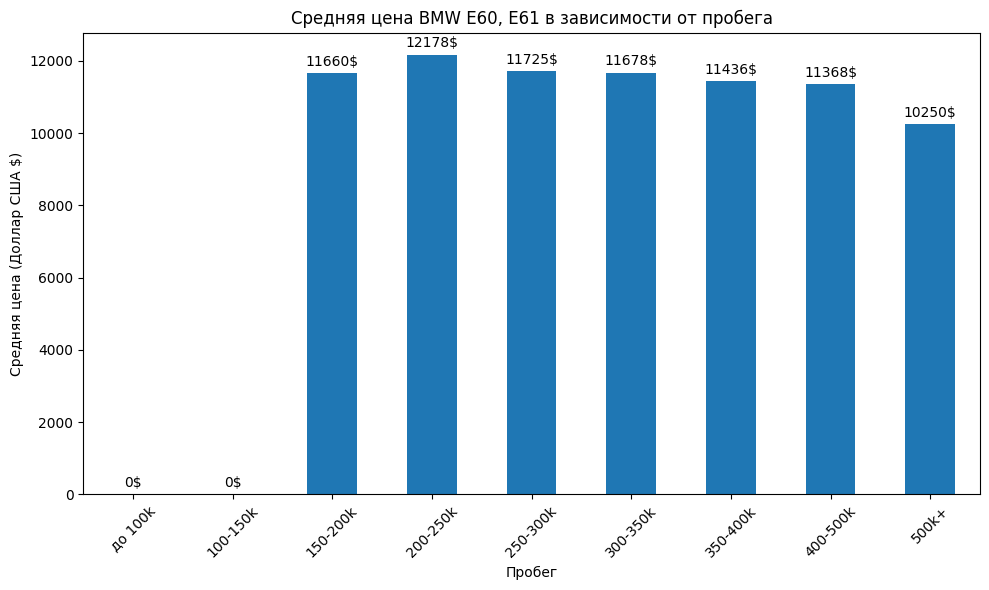

In [44]:
# Средняя цена поколения E60, E61 в зависимости от пробега

# Фильтруем только E60, E61
e60_61 = data[data['Поколение'] == 'E60, E61']

# Биннинг пробега для наглядности (например, по 50 000 км)
bins = [0, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 500000, 600000]
labels = [
    'до 100k', '100-150k', '150-200k', '200-250k', '250-300k',
    '300-350k', '350-400k', '400-500k', '500k+'
]
e60_61['Пробег_группа'] = pd.cut(e60_61['Пробег'], bins=bins, labels=labels, right=False, include_lowest=True)

# Группируем и считаем среднюю цену по группам пробега
avg_price_by_mileage = (
    e60_61
    .groupby('Пробег_группа')['Цена']
    .mean()
    .reindex(labels)  # чтобы порядок был как в labels
)

plt.figure(figsize=(10, 6))
ax = avg_price_by_mileage.plot(kind='bar')
ax.bar_label(ax.containers[0], fmt='%.0f$', padding=3)
plt.xlabel('Пробег')
plt.ylabel('Средняя цена (Доллар США $)')
plt.title('Средняя цена BMW E60, E61 в зависимости от пробега')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\trxxnk\AppData\Local\Temp\ipykernel_9460\1455767624.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_bin = temp.groupby('Год_группа')['Цена'].mean().dropna()


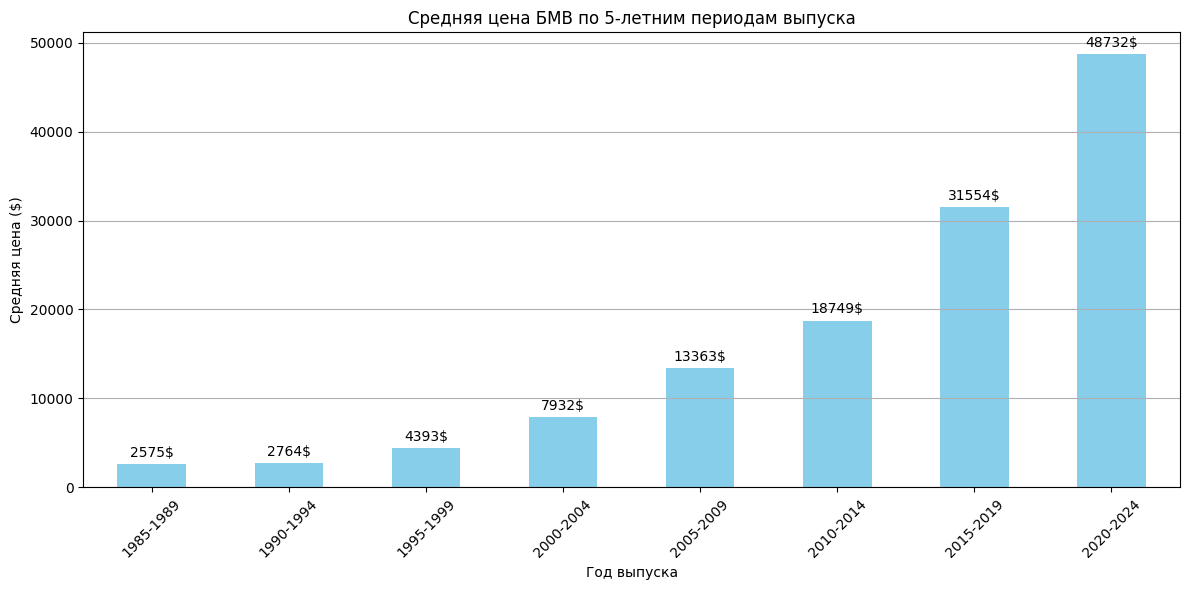

In [45]:
# Средняя цена БМВ по 5-летним периодам выпуска
bins = range(1985, 2030, 5)  # 1985-1990, 1990-1995, ...
labels = [f"{start}-{end-1}" for start, end in zip(bins[:-1], bins[1:])]  # Подписи: "1985-1989", "1990-1994"...

temp = data[['Год', 'Цена']].copy()

# Группировка по бинам
temp['Год_группа'] = pd.cut(
    temp['Год'],
    bins=bins,
    labels=labels,
    right=False  # Интервал [start, end), т.е. 1985-1989, 1990-1994...
)

avg_price_by_bin = temp.groupby('Год_группа')['Цена'].mean().dropna()

plt.figure(figsize=(12, 6))
ax = avg_price_by_bin.plot(kind='bar', color='skyblue')
ax.bar_label(ax.containers[0], fmt='%.0f$', padding=3)
plt.title('Средняя цена БМВ по 5-летним периодам выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя цена ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Наблюдение: при смене временных интревалов может сильно меняться цена; идея использования скользящего/оконного среднего

C:\Users\trxxnk\AppData\Local\Temp\ipykernel_9460\2911834804.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_bin = temp.groupby('Год_группа')['Цена'].mean().dropna()


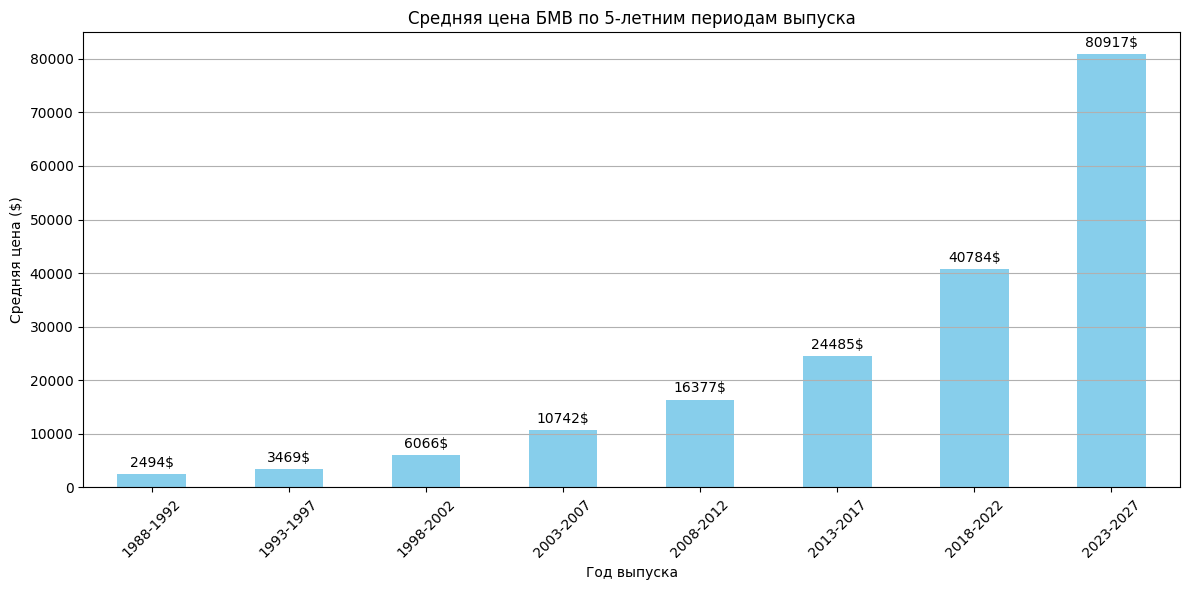

In [46]:
# Средняя цена БМВ по 5-летним периодам выпуска
bins = range(1988, 2030, 5)  # 1985-1990, 1990-1995, ...
labels = [f"{start}-{end-1}" for start, end in zip(bins[:-1], bins[1:])]  # Подписи: "1985-1989", "1990-1994"...

temp = data[['Год', 'Цена']].copy()

# Группировка по бинам
temp['Год_группа'] = pd.cut(
    temp['Год'],
    bins=bins,
    labels=labels,
    right=False  # Интервал [start, end), т.е. 1985-1989, 1990-1994...
)

avg_price_by_bin = temp.groupby('Год_группа')['Цена'].mean().dropna()

plt.figure(figsize=(12, 6))
ax = avg_price_by_bin.plot(kind='bar', color='skyblue')
ax.bar_label(ax.containers[0], fmt='%.0f$', padding=3)
plt.title('Средняя цена БМВ по 5-летним периодам выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя цена ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Преобразование данных

In [47]:
# Создаем копию DataFrame для преобразований
data_encoded = data.copy()

### 1. Коробка

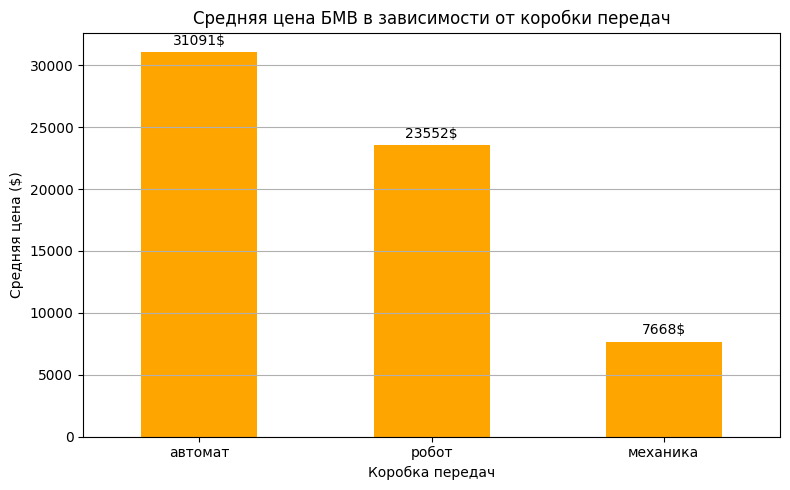

In [48]:
# Средняя цена в зависимости от типа коробки передач
avg_price_by_gearbox = data.groupby('Коробка')['Цена'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
ax = avg_price_by_gearbox.plot(kind='bar', color='orange')
ax.bar_label(ax.containers[0], fmt='%.0f$', padding=3)
plt.title('Средняя цена БМВ в зависимости от коробки передач')
plt.xlabel('Коробка передач')
plt.ylabel('Средняя цена ($)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [49]:
data['Коробка'].value_counts()

Коробка
автомат     1927
механика     536
робот        150
Name: count, dtype: int64

Так как БМВ с АКПП в среднем самые дорогие и на МКПП самые дешевые, а целевой меткой является цена, то логичнее будет применить Label Encoding по следующему правилу:
- Автомат → 2
- Робот → 1
- Механика → 0

**Примечание**: попрбовать encoding с учетом разницы средней цены (н-р, автомат в среднем на 10к$ дороже робота, а механика дешевле их обоих на +- 20к$, т.е. механика → 0, робот → 0.77, автомат → 1)

In [50]:
# Коробка передач → Label Encoding с заданным порядком
box_order = ['механика', 'робот', 'автомат']  # Явно задаем порядок
data_encoded['Коробка'] = data_encoded['Коробка'].astype('category').cat.set_categories(
    box_order, ordered=True
).cat.codes

### 2. Кузов

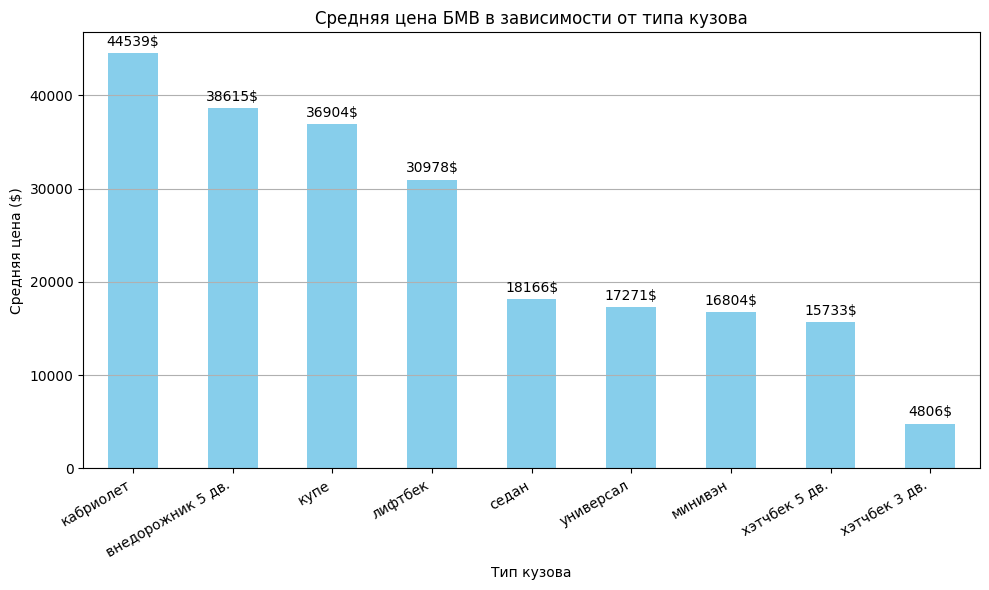

In [51]:
# Средняя цена в зависимости от типа кузова
avg_price_by_body = data.groupby('Кузов')['Цена'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
ax = avg_price_by_body.plot(kind='bar', color='skyblue')
ax.bar_label(ax.containers[0], fmt='%.0f$', padding=3)
plt.title('Средняя цена БМВ в зависимости от типа кузова')
plt.xlabel('Тип кузова')
plt.ylabel('Средняя цена ($)')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

По диаграмме видно, что кузов сильно влияет на цену автомобиля, но при этом некоторые кузова находятся в +- одном ценом сегменте (н-р, седан + универсал + минивэн и внедрожник + купе), и вот уже между этими сегментами разница в цене очень значительна. Можно применить label encoding по возрастанию с самого дешевого кузова, тем самым как и с кодированием информации о типе коробке, можно большим числом подчеркнуть большую цену. Аналогично, можно взять во внаимание разбег в ценах и более грамотно просчитать относительные коэфффициенты (в одном сегменте коэффициенты несильно отличаются, но между автомобилями из разных ценовых сегментов разница значительна).

Интереса ради попробуем применить One-Hot Encoder, чтобы модель попробоавала сама подобрать коэффицеинт дороговизны каждому кузову. Это сильно увеличит количество фич, но проект учебный, так что почему бы и нет?

In [52]:
# 4. Кузов → One-Hot Encoding
data_encoded = pd.get_dummies(data_encoded, columns=['Кузов'], prefix='Кузов', dtype=int)

In [53]:
data_encoded.head()

,Серия,Поколение,Год,Рестайлинг,Пробег,Коробка,Объем,Топливо,Цена,Кузов_внедорожник 5 дв.,Кузов_кабриолет,Кузов_купе,Кузов_лифтбек,Кузов_минивэн,Кузов_седан,Кузов_универсал,Кузов_хэтчбек 3 дв.,Кузов_хэтчбек 5 дв.
0,1 серия,F40,2019,0,129000,1,1.5,дизель,16999,0,0,0,0,0,0,0,0,1
1,7 серия,G12,2019,1,35000,2,3.0,дизель,83777,0,0,0,0,0,1,0,0,0
2,5 серия,E39,1999,0,400000,0,2.5,дизель,3399,0,0,0,0,0,1,0,0,0
3,1 серия,"E81, E82, E88, E87",2005,0,370000,2,2.0,бензин,7200,0,0,0,0,0,0,0,0,1
4,X6,E71,2012,1,149000,2,3.0,бензин,23450,1,0,0,0,0,0,0,0,0


### 3. Топливо

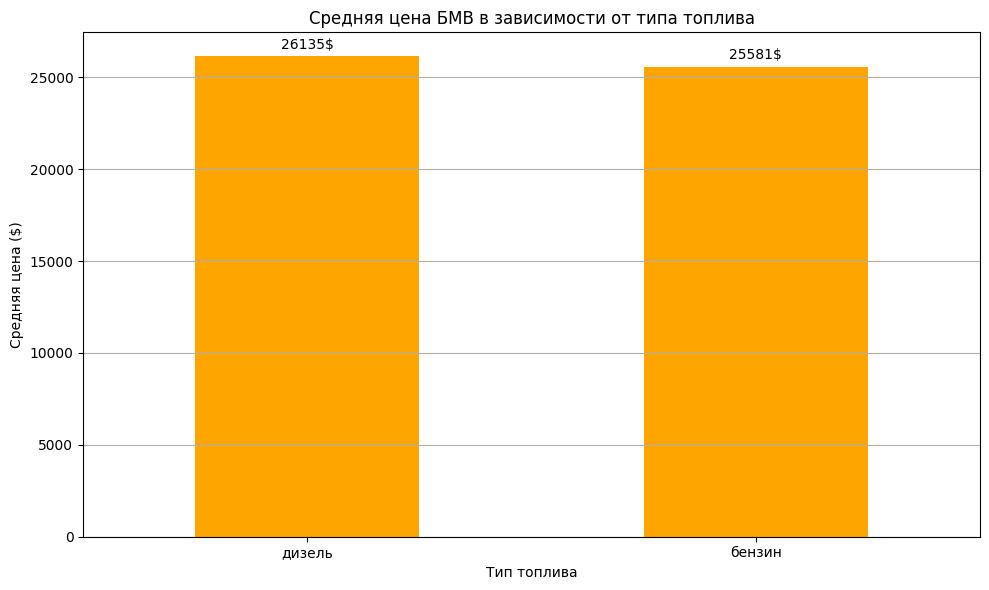

In [54]:
# Средняя цена в зависимости от типа топлива
avg_price_by_fuel = data.groupby('Топливо')['Цена'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
ax = avg_price_by_fuel.plot(kind='bar', color='orange')
ax.bar_label(ax.containers[0], fmt='%.0f$', padding=3)
plt.title('Средняя цена БМВ в зависимости от типа топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Средняя цена ($)')
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [55]:
data['Топливо'].value_counts()

Топливо
бензин    1330
дизель    1283
Name: count, dtype: int64

С топвливом оказывается все просто: средняя цена на дизельные и бензиновые БМВ отличается несильно, также видим, что объвлений с данными видами топлива поровну, так что вполне спокойно можно удалить этот признак, так как он не дает информации о повышении\понижении цены. К тому же вид топлива может вытекать из типа коробки, кузова и серии автомобиля (обратное в общем тоже верно).

In [56]:
# Пожайлуй погорячился с удалением столбца Топливо,
# можно накрутить нелинейный комбинаторный признак,
# который будет учитывать взаимодействие топлива и коробки передач
# data_encoded.drop(['Топливо'], axis=1, inplace=True)

<Figure size 1000x600 with 0 Axes>

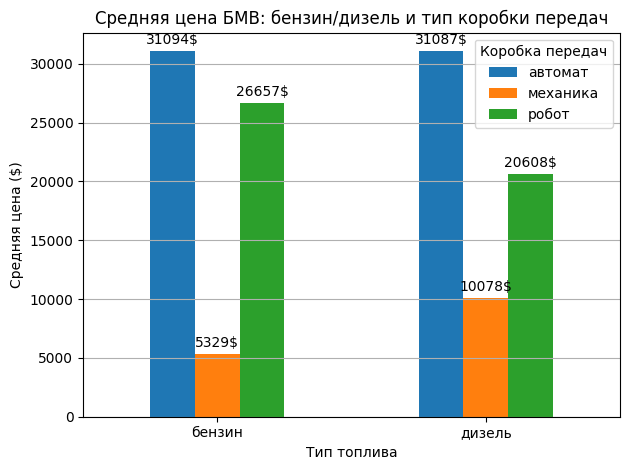

In [57]:
# Статистика по средней цене между бензиновыми и дизельными БМВ в зависимости от коробки передач

# Группируем по 'Топливо' и 'Коробка', считаем среднюю цену
avg_price_fuel_gearbox = data.groupby(['Топливо', 'Коробка'])['Цена'].mean().unstack()

plt.figure(figsize=(10,6))
ax = avg_price_fuel_gearbox.plot(kind='bar')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f$', padding=3)
plt.title('Средняя цена БМВ: бензин/дизель и тип коробки передач')
plt.xlabel('Тип топлива')
plt.ylabel('Средняя цена ($)')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Коробка передач')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Диаграмма выше показывает, что БМВ на АКПП с дизельным и бензиновым топливом стоят одинаково, при этом бензиновая БМВ в 2 раза дешевле дизельной. То есть связка из типа коробки и топлива серьезно влияет на цену машины, хотя в отдельности информация о топливе не дает ничего. Эту связь можно было бы описать при помощи многослойной НС?

In [58]:
data_encoded = pd.get_dummies(data_encoded, columns=['Топливо'], prefix='Топливо', dtype=int)
data_encoded

,Серия,Поколение,Год,Рестайлинг,Пробег,Коробка,Объем,Цена,Кузов_внедорожник 5 дв.,Кузов_кабриолет,Кузов_купе,Кузов_лифтбек,Кузов_минивэн,Кузов_седан,Кузов_универсал,Кузов_хэтчбек 3 дв.,Кузов_хэтчбек 5 дв.,Топливо_бензин,Топливо_дизель
0,1 серия,F40,2019,0,129000,1,1.5,16999,0,0,0,0,0,0,0,0,1,0,1
1,7 серия,G12,2019,1,35000,2,3.0,83777,0,0,0,0,0,1,0,0,0,0,1
2,5 серия,E39,1999,0,400000,0,2.5,3399,0,0,0,0,0,1,0,0,0,0,1
3,1 серия,"E81, E82, E88, E87",2005,0,370000,2,2.0,7200,0,0,0,0,0,0,0,0,1,1,0
4,X6,E71,2012,1,149000,2,3.0,23450,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,3 серия,"G20, G21",2022,1,8540,2,3.0,59990,0,0,0,0,0,1,0,0,0,1,0
2788,X6,E71,2011,0,277000,2,3.0,22290,1,0,0,0,0,0,0,0,0,0,1
2789,5 серия,"F10, F11",2012,0,256000,2,3.0,23500,0,0,0,0,0,1,0,0,0,0,1
2790,4 серия,"F32, F33, F36",2013,0,268500,2,2.0,21500,0,0,1,0,0,0,0,0,0,1,0


### 4. Серия и поколение

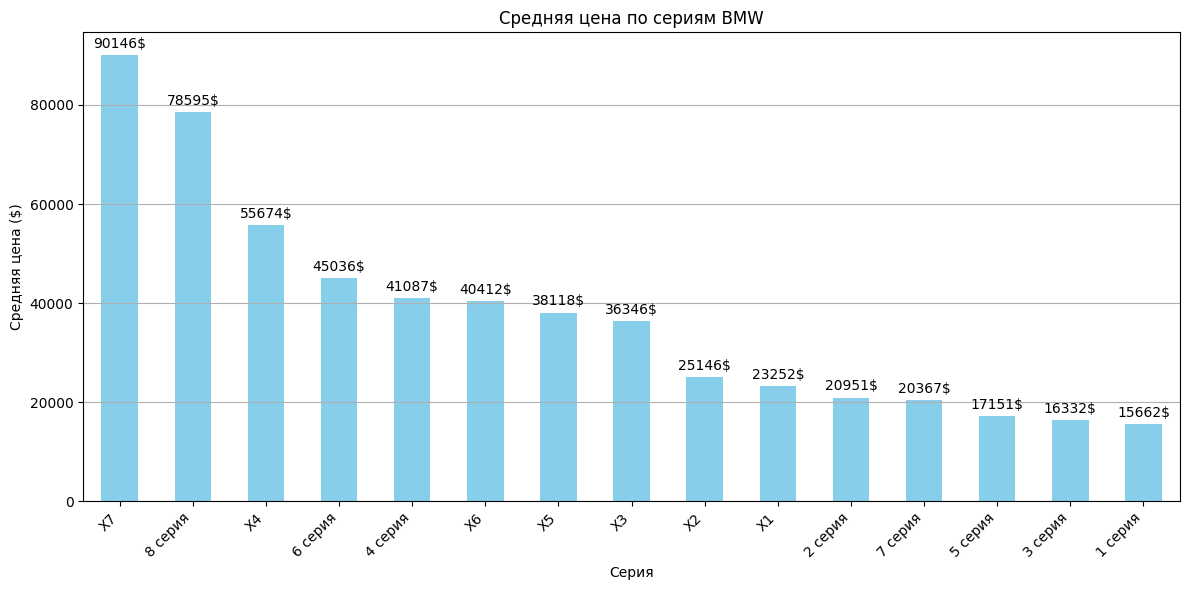

In [59]:
# Средняя цена по сериям БМВ
avg_price_by_series = data.groupby('Серия')['Цена'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
ax = avg_price_by_series.plot(kind='bar', color='skyblue')
for container in ax.containers if hasattr(ax, 'containers') else []:
    ax.bar_label(container, fmt='%.0f$', padding=3)
plt.title('Средняя цена по сериям BMW')
plt.xlabel('Серия')
plt.ylabel('Средняя цена ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

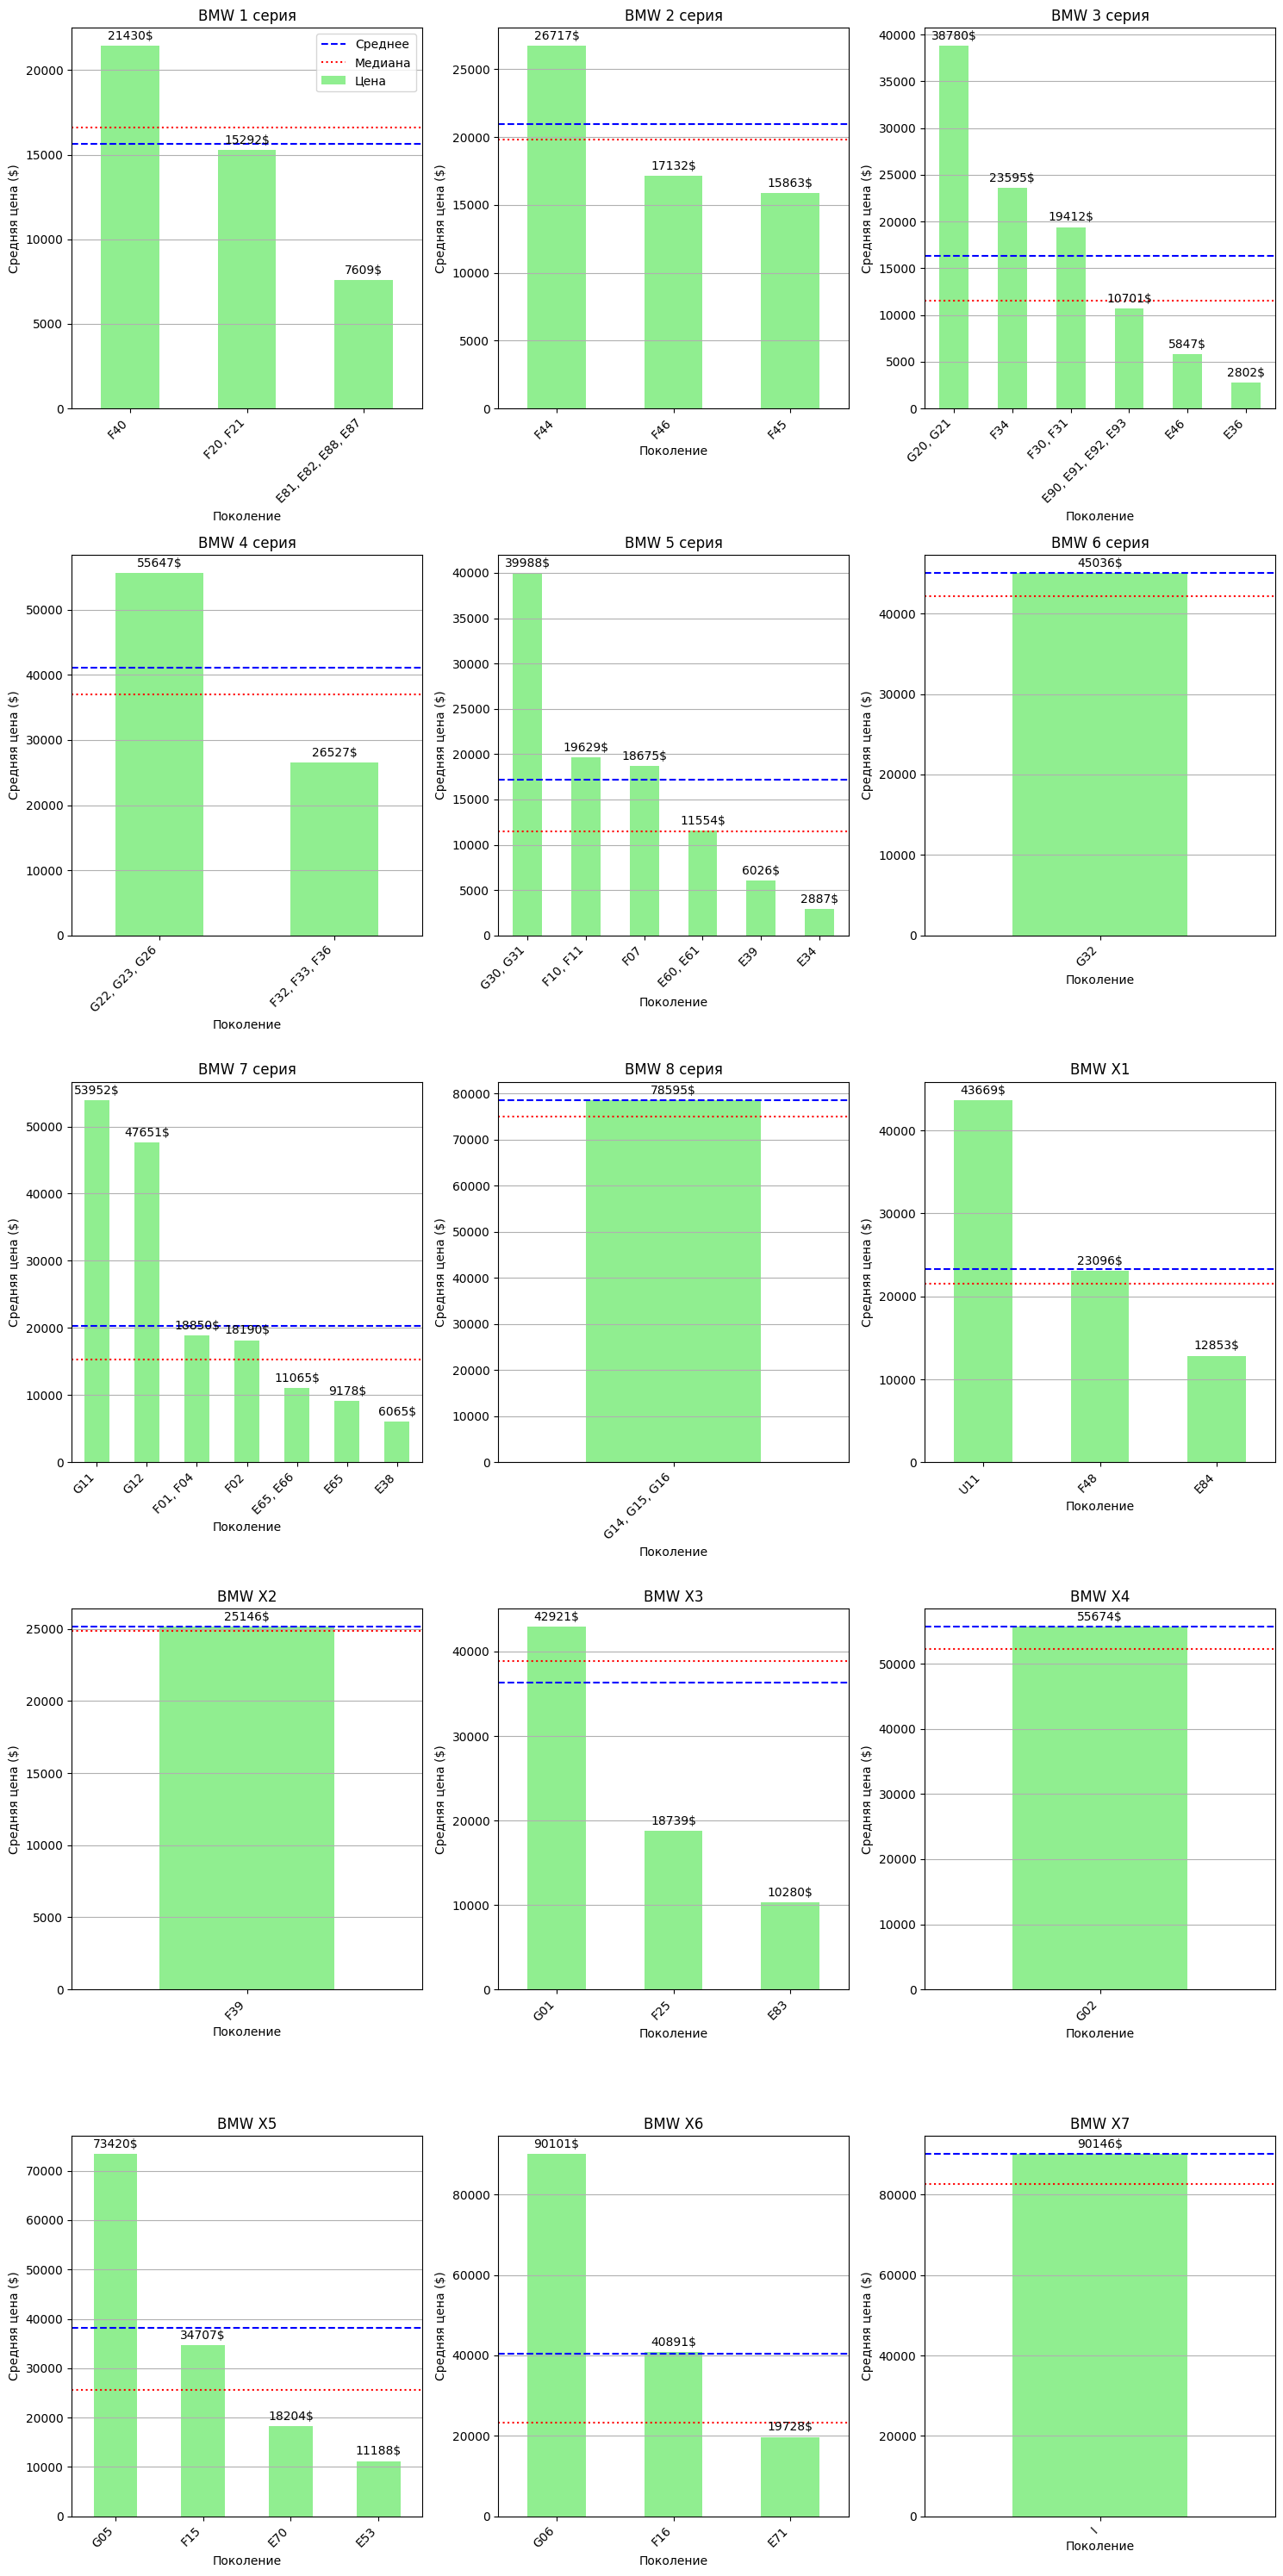

In [60]:
# Средняя цена по сериям и поколениям БМВ

series_list = data['Серия'].unique()
series_list.sort()
n_series = len(series_list)

# Определим количество столбцов и строк для сетки
n_cols = 3  # например, 3 столбца
n_rows = n_series // n_cols + (1 if n_series % n_cols != 0 else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*6))
axes = axes.flatten()  # для удобства индексации

for idx, series in enumerate(series_list):
    ax = axes[idx]
    series_data = data[data['Серия'] == series]
    avg_price_by_generation = series_data.groupby('Поколение')['Цена'].mean().sort_values(ascending=False)
    avg_price_by_generation.plot(kind='bar', color='lightgreen', ax=ax)
    for container in ax.containers if hasattr(ax, 'containers') else []:
        ax.bar_label(container, fmt='%.0f$', padding=3)
    # Добавим горизонтальные линии средней и медианы по серии
    mean_price = series_data['Цена'].mean()
    median_price = series_data['Цена'].median()
    ax.axhline(mean_price, color='blue', linestyle='--', linewidth=1.5, label='Среднее')
    ax.axhline(median_price, color='red', linestyle=':', linewidth=1.5, label='Медиана')
    ax.set_title(f'BMW {series}')
    ax.set_xlabel('Поколение')
    ax.set_ylabel('Средняя цена ($)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y')
    ax.set_ylim(bottom=0)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    # Добавим легенду только если это первый график
    if idx == 0:
        ax.legend()

# Отключим пустые подграфики, если есть
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [61]:
encoder = TargetEncoder(smooth=10, cv=5, target_type='continuous')  # Автоматическая кросс-валидация
data_encoded['Поколение'] = encoder.fit_transform(
    data['Поколение'].values.reshape(-1, 1), 
    data['Цена'].values).astype(int)

data_encoded['Серия'] = encoder.fit_transform(
    data['Серия'].values.reshape(-1, 1), 
    data['Цена'].values).astype(int)

data_encoded

,Серия,Поколение,Год,Рестайлинг,Пробег,Коробка,Объем,Цена,Кузов_внедорожник 5 дв.,Кузов_кабриолет,Кузов_купе,Кузов_лифтбек,Кузов_минивэн,Кузов_седан,Кузов_универсал,Кузов_хэтчбек 3 дв.,Кузов_хэтчбек 5 дв.,Топливо_бензин,Топливо_дизель
0,17140,22517,2019,0,129000,1,1.5,16999,0,0,0,0,0,0,0,0,1,0,1
1,20542,40126,2019,1,35000,2,3.0,83777,0,0,0,0,0,1,0,0,0,0,1
2,17574,7029,1999,0,400000,0,2.5,3399,0,0,0,0,0,1,0,0,0,0,1
3,17681,13564,2005,0,370000,2,2.0,7200,0,0,0,0,0,0,0,0,1,1,0
4,39427,21047,2012,1,149000,2,3.0,23450,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,15881,36993,2022,1,8540,2,3.0,59990,0,0,0,0,0,1,0,0,0,1,0
2788,38714,21047,2011,0,277000,2,3.0,22290,1,0,0,0,0,0,0,0,0,0,1
2789,17574,20410,2012,0,256000,2,3.0,23500,0,0,0,0,0,1,0,0,0,0,1
2790,38991,26413,2013,0,268500,2,2.0,21500,0,0,1,0,0,0,0,0,0,1,0


### Итоги 

Применили следующие преобразования к категориальным признакам:
1. `Коробка` - **Label Encoding**, т.к. есть порядок по цене (механика < автомат < робот).
2. `Кузов` - **One-Hot Encoding**, хотя здесь так напрашивается **Label Encoding**, так как средняя цена на кузова типа кабриолета цена очевидно дороже, в же время базовые седаны и внедорожники дешевле (по сути связано с массовостью производства). Был выбран **One-Hot Encoding**, чтобы посмореть, увидит ли модель во время обучения, какие из кузов являются более дорогими.
3. `Топливо` -  **One-Hot Encoding**, была замечена интересная зависимость в цене, если рассматривать в совокупности с `Коробкой`.
4. `Серия и поколение` - оба при помощи **Target Encoding**, скорее не лучшее решение, но это было что-то новое для меня и все-таки имеет смысл. Суть в том, что буквально заменили названия на среднюю цену по данной группе, причем предварительно разбили данные на несколько непересекающихся фолдов, чтобы избежать переобучения в будущем.

Примечания:
- К фичам `Объем` (двигателя) и `Пробег` можно тоже относится как к категориальным, пока что этот момемент пропустим, чтобы наконец перейти к этапу подбора моделей и обучения.
- Ну все погнали мучать компик итерациями обучения, я думаю скоро вернусь к этому блокноту с анализом, так как нифига дельного не выйдет) 😁😁😁

## Сохранение преобразованных данных

In [62]:
data_encoded.head()

,Серия,Поколение,Год,Рестайлинг,Пробег,Коробка,Объем,Цена,Кузов_внедорожник 5 дв.,Кузов_кабриолет,Кузов_купе,Кузов_лифтбек,Кузов_минивэн,Кузов_седан,Кузов_универсал,Кузов_хэтчбек 3 дв.,Кузов_хэтчбек 5 дв.,Топливо_бензин,Топливо_дизель
0,17140,22517,2019,0,129000,1,1.5,16999,0,0,0,0,0,0,0,0,1,0,1
1,20542,40126,2019,1,35000,2,3.0,83777,0,0,0,0,0,1,0,0,0,0,1
2,17574,7029,1999,0,400000,0,2.5,3399,0,0,0,0,0,1,0,0,0,0,1
3,17681,13564,2005,0,370000,2,2.0,7200,0,0,0,0,0,0,0,0,1,1,0
4,39427,21047,2012,1,149000,2,3.0,23450,1,0,0,0,0,0,0,0,0,1,0


In [63]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2613 entries, 0 to 2791
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Серия                    2613 non-null   int64  
 1   Поколение                2613 non-null   int64  
 2   Год                      2613 non-null   int64  
 3   Рестайлинг               2613 non-null   int64  
 4   Пробег                   2613 non-null   int64  
 5   Коробка                  2613 non-null   int8   
 6   Объем                    2613 non-null   float64
 7   Цена                     2613 non-null   int64  
 8   Кузов_внедорожник 5 дв.  2613 non-null   int64  
 9   Кузов_кабриолет          2613 non-null   int64  
 10  Кузов_купе               2613 non-null   int64  
 11  Кузов_лифтбек            2613 non-null   int64  
 12  Кузов_минивэн            2613 non-null   int64  
 13  Кузов_седан              2613 non-null   int64  
 14  Кузов_универсал          2613

In [64]:
data_encoded.to_csv("../data/bmw_encoded.csv", index=False)